In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import seaborn as sns # Wrapper for matplotlib
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression # Linear model
import tensorflow as tf

from ucimlrepo import fetch_ucirepo # Dataset API: https://github.com/uci-ml-repo/ucimlrepo

import json
import pprint

### Dataset:
Markelle Kelly, Rachel Longjohn, Kolby Nottingham,
The UCI Machine Learning Repository, https://archive.ics.uci.edu

Source: Seoul Bike Sharing Demand. (2020). UCI Machine Learning Repository. https://doi.org/10.24432/C5F62R.

## Focus: Bike Count

In [2]:
# Fetch dataset through API
seoul_bike_sharing_demand = fetch_ucirepo(id=560)

# Data (as pandas dataframes)
X = seoul_bike_sharing_demand.data.features
y = seoul_bike_sharing_demand.data.targets

# Build the whole dataframe/dataset: X + y
df = X
df = df.assign(**y)

# Metadata
metadata = seoul_bike_sharing_demand.metadata

# Variable information
variables = seoul_bike_sharing_demand.variables

### Dataset Metadata

In [3]:
pprint.pprint(metadata)
print("########################################################################################")
variables

{'abstract': 'The dataset contains count of public bicycles rented per hour in '
             'the Seoul Bike Sharing System, with corresponding weather data '
             'and holiday information',
 'additional_info': {'citation': None,
                     'funded_by': None,
                     'instances_represent': None,
                     'preprocessing_description': None,
                     'purpose': None,
                     'recommended_data_splits': None,
                     'sensitive_data': None,
                     'summary': 'Currently Rental bikes are introduced in many '
                                'urban cities for the enhancement of mobility '
                                'comfort. It is important to make the rental '
                                'bike available and accessible to the public '
                                'at the right time as it lessens the waiting '
                                'time. Eventually, providing the city with a '
 

,name,role,type,demographic,description,units,missing_values
0,Date,Feature,Date,None,None,None,no
1,Rented Bike Count,Feature,Integer,None,None,None,no
2,Hour,Feature,Integer,None,None,None,no
3,Temperature,Feature,Continuous,None,None,C,no
4,Humidity,Feature,Integer,None,None,%,no
5,Wind speed,Feature,Continuous,None,None,m/s,no
6,Visibility,Feature,Integer,None,None,10m,no
7,Dew point temperature,Feature,Continuous,None,None,C,no
8,Solar Radiation,Feature,Continuous,None,None,Mj/m2,no
9,Rainfall,Feature,Integer,None,None,mm,no


In [4]:
df.head()

,Date,Rented Bike Count,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning Day
0,1/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,1/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,1/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,1/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,1/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [5]:
# Drop some columns we don't care about
# These are mostly qualitative rather than quantitative
df = df.drop(["Date", "Holiday", "Seasons"], axis=1)

In [6]:
# Help the machine determine class by converting to int
# Yes = 1, No = 0
df["Functioning Day"] = (df["Functioning Day"] == "Yes").astype(int)

In [7]:
df = df[df["Hour"] == 12] # Select noon samples
df = df.drop(["Hour"], axis=1)
df.head()

,Rented Bike Count,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Functioning Day
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


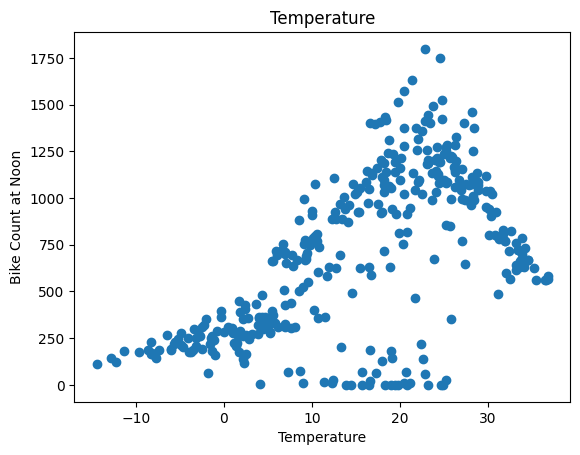

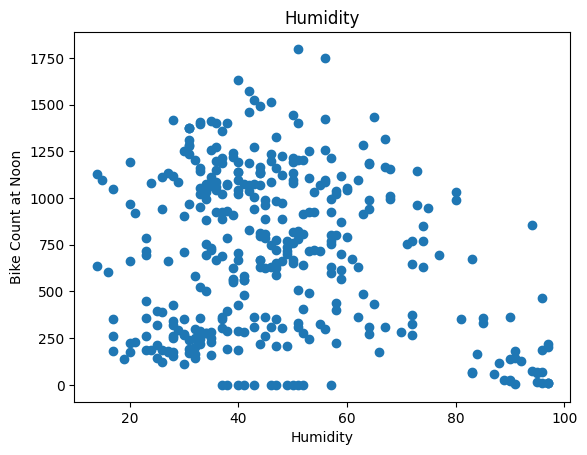

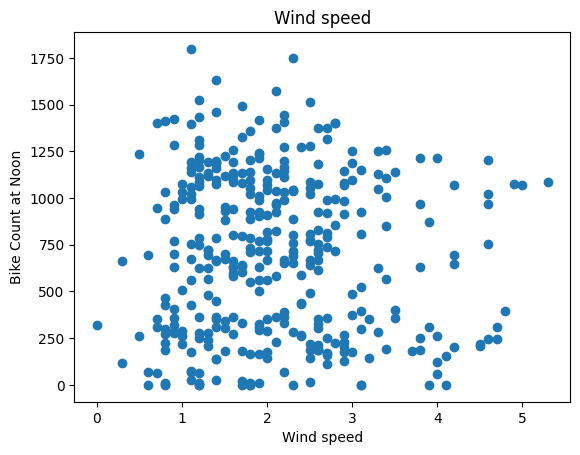

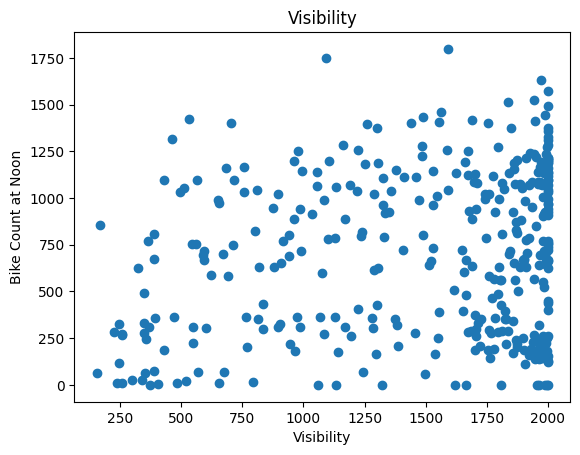

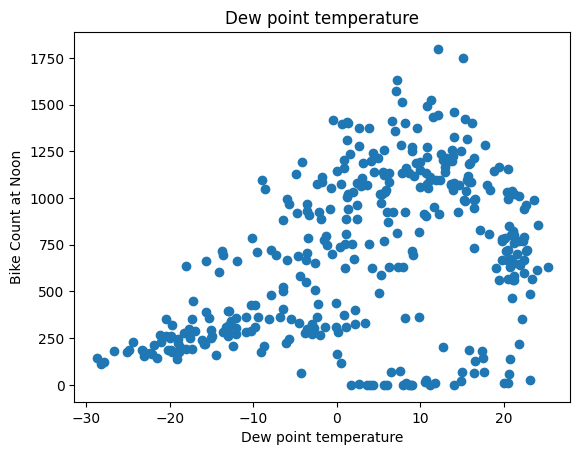

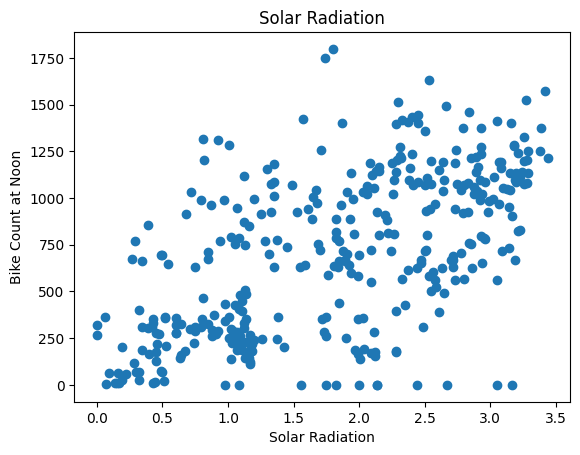

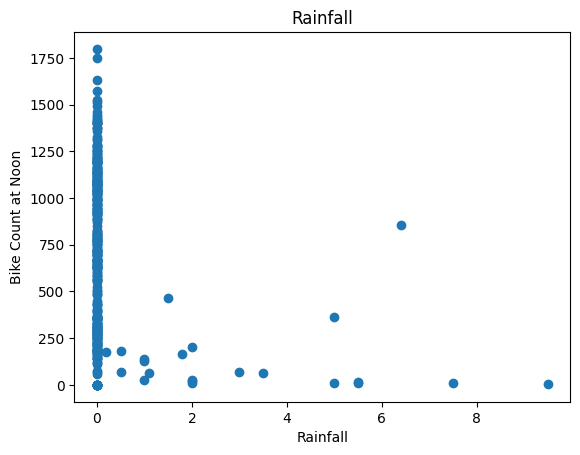

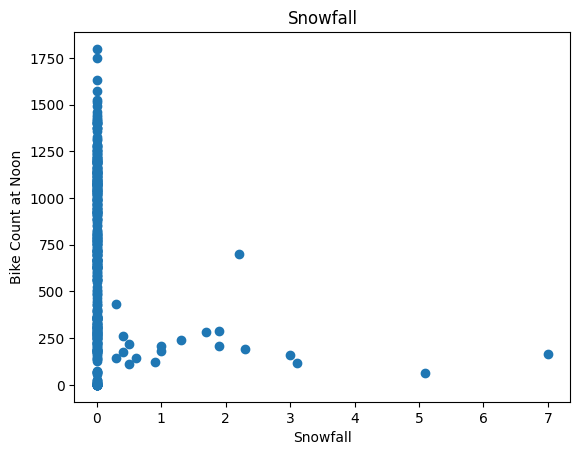

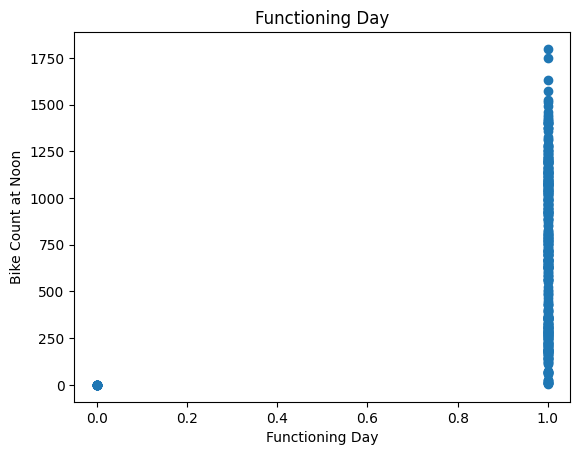

In [8]:
# Each chart represents a different feature
# Use these visuals to discern correlations and get a good idea of what feature affects the final output
for label in df.columns[1:]:
    plt.scatter(df[label], df["Rented Bike Count"])
    plt.title(label)
    plt.ylabel("Bike Count at Noon")
    plt.xlabel(label)
    plt.show()

## Some Observations

Bike count does not appear linear with respect to some of these features (keep in mind for neural net)

**Temperature:** looks quite linear

**Humidity:** maybe negative linear

**Wind speed:** not really

**Visibility:** not really

**Dew point temperature:** maybe

**Solar Radiation:** fairly linear

**Rainfall:** no utility

**Snowfall:** no utility

**Functioning Day:** no utility

In [9]:
# Drop columns that don't appear to have any correlations
df = df.drop(["Wind speed", "Visibility", "Functioning Day"], axis=1)
df.head()

,Rented Bike Count,Temperature,Humidity,Dew point temperature,Solar Radiation,Rainfall,Snowfall
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


# Train, Validation, Test Datasets

In [10]:
# Train: 60%, Validation: 20%, Test: 20%
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

D:\Python_Projects\MachineLearning\LearnMachineLearning\venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [11]:
def get_xy(dataframe, y_label, x_labels=None):
    """
    Gets X and y from dataframe and returns them along with the full dataframe
    
    dataframe: dataframe
    y_label (str): the target label
    x_labels (list): the features we want to look at, default None (which selects all)

    Returns:
        Dataset,
        X part,
        y part
    """
    dataframe = copy.deepcopy(dataframe)

    # No x_labels specified, select all features
    if x_labels is None:
        X = dataframe[[c for c in dataframe.columns if c != y_label]].values
    # x_labels specified
    else:
        if len(x_labels) == 1:
            # Pandas documentations recommends using DataFrame.to_numpy() instead of DataFrame.values
            #X = dataframe[x_labels[0]].values.reshape(-1, 1)
            X = dataframe[x_labels[0]].to_numpy().reshape(-1, 1) # Reshape to 2D array
        else:
            # Pandas documentations recommends using DataFrame.to_numpy() instead of DataFrame.values
            #X = dataframe[x_labels].values
            X = dataframe[x_labels].to_numpy()

    y = dataframe[y_label].values.reshape(-1, 1)
    # Stack the arrays horizontally
    data = np.hstack((X, y))

    return data, X, y

# Linear Regression (Focusing on Temperature)

In [12]:
_, X_train_temp, y_train_temp = get_xy(train, y_label="Rented Bike Count", x_labels=["Temperature"])
_, X_val_temp, y_val_temp = get_xy(val, y_label="Rented Bike Count", x_labels=["Temperature"])
_, X_test_temp, y_test_temp = get_xy(test, y_label="Rented Bike Count", x_labels=["Temperature"])

In [13]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp) # Fit training data

LinearRegression()

In [14]:
# Print regressor's coefficients, y-intercept, and R^2 score
print(temp_reg.coef_, temp_reg.intercept_)
print(temp_reg.intercept_)
print(temp_reg.score(X_test_temp, y_test_temp))

[[18.83398995]] [380.55746338]
[380.55746338]
0.3515468956789124


Since the R^2 is not close to 0, there is an association, but it isn't the best association

**R^2 Range:** [0, 1]

**Recorded:** 0.38

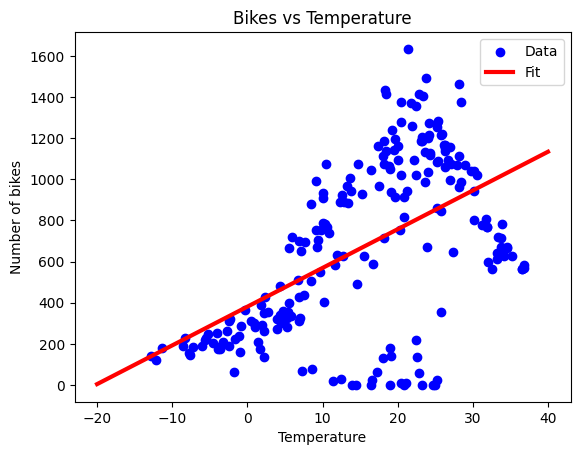

In [15]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 2)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temperature")
plt.ylabel("Number of bikes")
plt.xlabel("Temperature")
plt.show()

# Multiple Linear Regression (All Selected Features)

In [16]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
_, X_train_all, y_train_all = get_xy(train, y_label="Rented Bike Count", x_labels=df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, y_label="Rented Bike Count", x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, y_label="Rented Bike Count", x_labels=df.columns[1:])

D:\Python_Projects\MachineLearning\LearnMachineLearning\venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [17]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [18]:
all_reg.score(X_test_all, y_test_all)

0.5142211913347157

R^2 score seems to have improved

**Recorded:** 0.48

# Regression with Neural Network (Focusing on Temperature)

In [19]:
def plot_loss(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE") # Mean Squared Error
    plt.legend()
    plt.grid(True)
    plt.show()

In [20]:
# Helps if we normalize
# We can do this easily with a TensorFlow normalization layer
# input_shape of 1 because we're only considering temperature
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

D:\Python_Projects\MachineLearning\LearnMachineLearning\venv\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    # 1 single dense layer with 1 single node (linear),
    # no activation function, thus linear output
    tf.keras.layers.Dense(1)
])

In [22]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss="mean_squared_error")

In [23]:
temp_history = temp_nn_model.fit(
    X_train_temp.reshape(-1), # Reshape to 1D as feature vector only contains 1 feature
    y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(X_val_temp, y_val_temp)
)

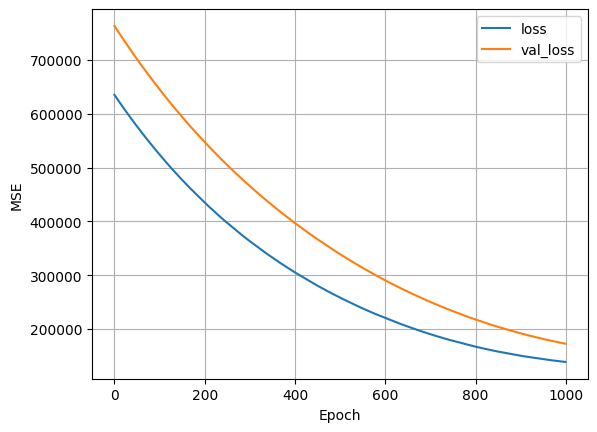

In [24]:
plot_loss(temp_history)

The lines are converging and loss is decreasing, which is good

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


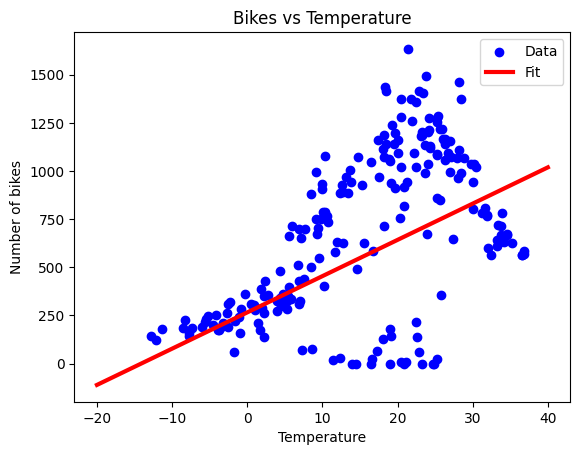

In [25]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 2)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temperature")
plt.ylabel("Number of bikes")
plt.xlabel("Temperature")
plt.show()

# Regression with "Neural Network" (All Selected Features)

In [26]:
# input_shape of 6 because we have 6 features
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=None)
all_normalizer.adapt(X_train_all.reshape(-1))

In [27]:
all_nn_model = tf.keras.Sequential([
    all_normalizer,
    # 1 single dense layer with 1 single unit (linear),
    # no activation function, thus linear output
    tf.keras.layers.Dense(1)
])

In [28]:
all_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss="mean_squared_error")

In [29]:
all_history = all_nn_model.fit(
    X_train_all,
    y_train_all.reshape(-1,), # Reshape to 2D, as X is 2D
    verbose=0,
    epochs=1000,
    validation_data=(X_val_all, y_val_all)
)

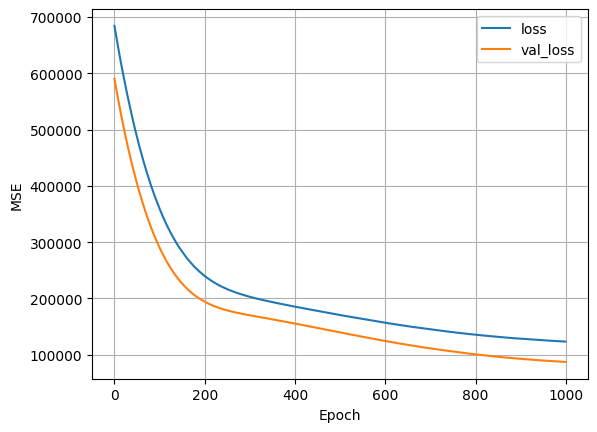

In [30]:
plot_loss(all_history)

The lines here are also converging with a decreasing loss, which is a good sign

# Neural Network (Temperature)

In [31]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1, activation="relu")
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mean_squared_error")

In [32]:
history = nn_model.fit(
    X_train_temp,
    y_train_temp,
    validation_data=(X_val_temp, y_val_temp),
    verbose=0,
    epochs=100
)

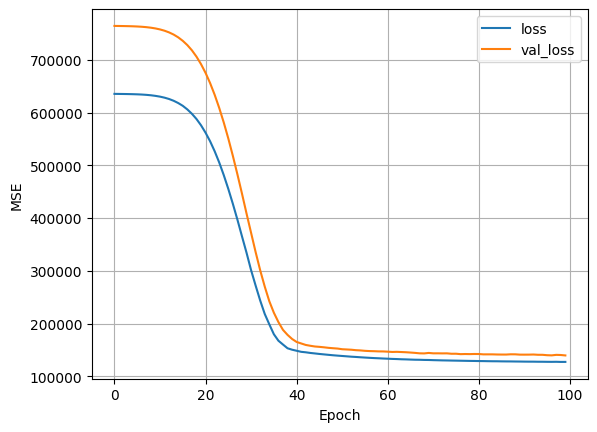

In [33]:
plot_loss(history)

The lines are converging and loss is decreasing, a good sign

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


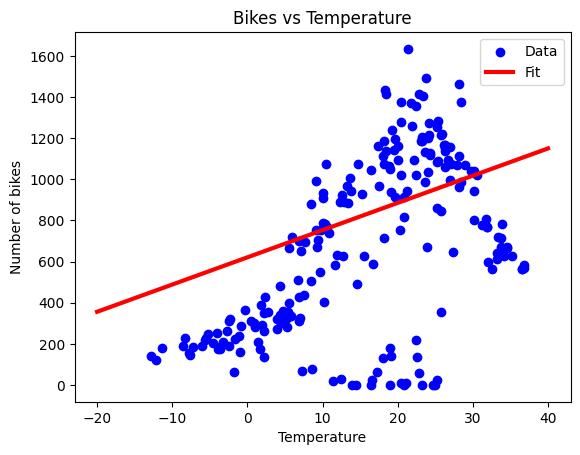

In [34]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 2)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temperature")
plt.ylabel("Number of bikes")
plt.xlabel("Temperature")
plt.show()

# Neural Network (All)

In [35]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=None) # axis -1
all_normalizer.adapt(X_train_all)

nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="mean_squared_error")

In [36]:
history = nn_model.fit(
    X_train_all,
    y_train_all,
    validation_data=(X_val_all, y_val_all),
    verbose=0,
    epochs=100
)

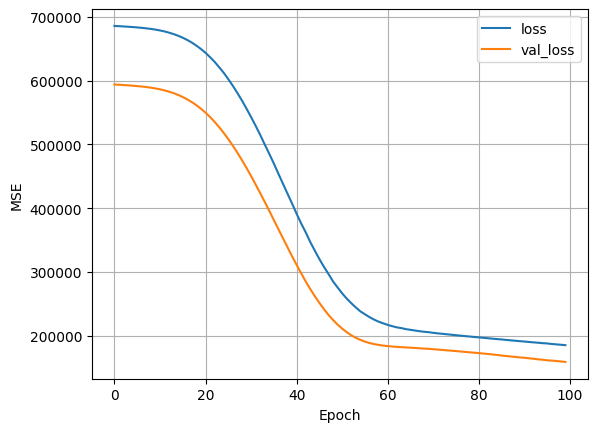

In [37]:
plot_loss(history)

In [38]:
# Calculate the MSE for both linear regressor and neural network
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [39]:
def MSE(y_pred, y_real):
    """Calculate the MSE
    
    y_pred: predicted y targets
    y_real: actual y targets

    Returns:
        MSE as float
    """
    return (np.square(y_pred - y_real)).mean()

In [40]:
print(MSE(y_pred_lr, y_test_all))
print(MSE(y_pred_nn, y_test_all))

83679.16405420624
149652.07545374922


It appears our linear regressor does better than our neural network

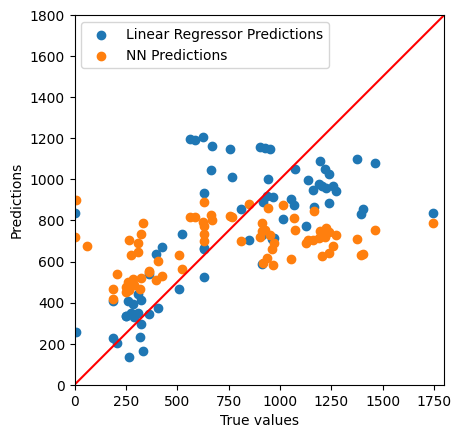

In [41]:
# Comparing our linear regressor and our neural network against our actual values
# We want the points (predictions) to get as close to the red line as possible
ax = plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred_lr, label="Linear Regressor Predictions")
plt.scatter(y_test_all, y_pred_nn, label="NN Predictions")
plt.xlabel("True values")
plt.ylabel("Predictions")
lims = [0, 1800] # Limits
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c="red")